In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
plt.style.use('ggplot')

In [2]:
def scale_factor_spectrum(z,data,error,wave):
    k = 1+z
    select1 = (wave>6750*k) & (wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact

In [43]:
def aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2=False,MC_loops=100):
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,int_spectrum,int_err),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,int_spectrum,int_err))*(int_err)+int_spectrum 
    residual = int_spectrum - fitted
    v_out = popt_full_fit[2] - popt_full_fit[6]
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = popt_full_fit
    
    sigma_eff_Hb_core = line_width_recons(vel_sigma_OIII,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_OIII_core = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
    
    sigma_eff_Hb_wing = line_width_recons(vel_sigma_OIII_br,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_OIII_wing = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)
    
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    
    flux = flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    flux_Hb_core = flux_nlr(amp_Hb,sigma_eff_Hb_core)
    flux_OIII_core = flux_nlr(amp_OIII5007,sigma_eff_OIII_core)
    flux_Hb_wing = flux_nlr(amp_Hb_br,sigma_eff_Hb_wing)
    flux_OIII_wing = flux_nlr(amp_OIII5007_br,sigma_eff_OIII_wing)
    
    Hb_lum = Hb_blr_lum(z,flux)          
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    w80 = line_shape_par(z,wav_min,wav_max,cor_popt)
    parameters = [amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c,v_out,w80,Hb_lum]
    full_flux = [flux_Hb_core,flux_Hb_wing,flux_OIII_core,flux_OIII_wing,flux]

    spec_parameters_MC = np.zeros((len(parameters),MC_loops))
    flux_par_MC = np.zeros((5,MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(int_spectrum,int_err)   
        popt_MC,pcov_MC = leastsq(full_gauss,x0=p_init,args=(mini_wave,iteration_data,int_err),maxfev = 10000000)
        v_out_MC = popt_MC[2] - popt_MC[6]
        
        (amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC) = popt_MC
        
        sigma_eff_Hb_core_MC = line_width_recons(vel_sigma_OIII_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_OIII_core_MC = line_width_recons(vel_sigma_OIII_MC,rest_line=5006.8,inst_res_fwhm=0)
    
        sigma_eff_Hb_wing_MC = line_width_recons(vel_sigma_OIII_br_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_OIII_wing_MC = line_width_recons(vel_sigma_OIII_br_MC,rest_line=5006.8,inst_res_fwhm=0)
    
        sigma_eff_Hb1_MC = line_width_recons(vel_sigma_Hb1_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_Hb2_MC = line_width_recons(vel_sigma_Hb2_MC,rest_line=4861.33,inst_res_fwhm=0) 
        
        flux_MC = flux_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        flux_Hb_core_MC = flux_nlr(amp_Hb_MC,sigma_eff_Hb_core_MC)
        flux_OIII_core_MC = flux_nlr(amp_OIII5007_MC,sigma_eff_OIII_core_MC)
        flux_Hb_wing_MC = flux_nlr(amp_Hb_br_MC,sigma_eff_Hb_wing_MC)
        flux_OIII_wing_MC = flux_nlr(amp_OIII5007_br_MC,sigma_eff_OIII_wing_MC)
    
        Hb_lum_MC = Hb_blr_lum(z,flux_MC)  
        cor_popt_MC = np.array([amp_OIII5007_MC,amp_OIII5007_br_MC,vel_OIII_MC,vel_sigma_OIII_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC])
        (wav_min,wav_max) = wavlim(vel_OIII_MC,vel_OIII_br_MC)
        w80_MC = line_shape_par(z,wav_min,wav_max,cor_popt_MC)
        par_MC = [amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC,v_out_MC,w80_MC,Hb_lum_MC]
        full_flux_MC = [flux_Hb_core_MC,flux_Hb_wing_MC,flux_OIII_core_MC,flux_OIII_wing_MC,flux_MC]
        spec_parameters_MC[:,l]=par_MC
        flux_par_MC[:,l]=full_flux_MC
    spec_parameters_err = np.nanstd(spec_parameters_MC,1)
    flux_par_err = np.nanstd(flux_par_MC,1)
    return parameters,spec_parameters_err,full_flux,flux_par_err,fitted,residual


In [44]:
def flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)#*(10**(-16))
    else:
        flux = flux1#*(10**(-16)) 
    return flux

def flux_nlr(amp,sigma_eff):
    flux = amp*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff))
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum
    
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
   # print (cumsum)
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
 
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80


In [45]:
def central_table(obj,output_par,output_par_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'w80':19,'log_Hb_lum':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def flux_table(obj,flux_complex,flux_complex_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'F_Hb_core':0,'F_Hb_wing':1,'F_OIII_core':2,'F_OIII-wing':3,'F_Hb_bblr':4}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[flux_complex[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[flux_complex_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_flux_Hb-OIII_3arcsecond.fits'%(destination_path_cube,obj,obj),overwrite=True)


def central_table_with_source(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_nonfixkin_aperture.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit,w80_fit,Hb_lum_fit) = popt
    output_par = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit] 
    k = 1+z
    k_act = 1+(vel_OIII_fit/300000)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(output_par,mini_wave,int_spectrum,int_err)*(int_err)+int_spectrum
    residual = int_spectrum - fit
    
    fig = plt.gcf()
    fig.set_size_inches(10, 9)
    plt.plot(mini_wave/k_act,int_spectrum,'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(mini_wave/k_act,fit,'r:',label='Model')
    plt.plot(mini_wave/k_act,continuum(mini_wave,m_fit,c_fit)+Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'H$\beta$ + [OIII] core')
    plt.plot(mini_wave/k_act,continuum(mini_wave,m_fit,c_fit)+Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label=r'H$\beta$ + [OIII] wing',linestyle='-.')
    plt.plot(mini_wave/k_act,continuum(mini_wave,m_fit,c_fit)+Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label=r'H$\beta$ + FeII BLR')
    plt.plot(mini_wave/k_act,residual,label='residual')
    #plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    plt.xlim(4750,5090)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),overwrite=True)

    #fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    

In [39]:
def spectroastrometric_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data/MUSE",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    k = 1+z
    print ('%s'%(obj))
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    print (brightest_pixel_x,brightest_pixel_y)

    select = (QSO_wave > 4750*k) & (QSO_wave < 5090*k)  
    mini_wave = QSO_wave[select]
    mini_cube = QSO_cube[:,brightest_pixel_y-10:brightest_pixel_y+11,brightest_pixel_x-10:brightest_pixel_x+11][select]
        
    (central_spec,central_error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])  
    select2 = (wo_wave>5030*k) & (wo_wave<5050*k)
    cont_data = central_spec[select2]
    S = np.mean(cont_data)
    N = np.std(cont_data)
    S_N = (S/N)
    SN = np.sqrt(mini_cube/S)*S_N
    err = np.sqrt(mini_cube*S)/S_N
    mini_err = err
    
    print (np.min(mini_cube))

    (int_spectrum,int_err) = int_spec(mini_cube,mini_err)
 
    (popt,popt_err,flux_complex,flux_complex_err,fitted,residual) = aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2,MC_loops=100)
    print (popt,popt_err)
    plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2)
    
    central_table(obj,popt,popt_err)
    central_table_with_source(obj)
    flux_table(obj,flux_complex,flux_complex_err)

HE0412-0803
179 160
9.103893245074356e-05
[25.991775042114266, 377.9021617151265, 11462.65398384369, 77.58884988793484, 13.45364927194849, 105.6775110533598, 11464.515564647943, 260.8847514676813, 39.13612631044738, 6.147403771765039, 11324.476521129676, 1802.641975965995, 0.0, 0.0, 11448.0, 1000.0, -7.922462888767156, 65.95459444017146, -1.8615808042541175, 415.5556734524695, 57.989380851528225] [4.31950120e-01 8.94727443e-01 1.42309871e-01 3.03098459e-01
 2.78147801e-01 8.61761827e-01 4.32794628e-01 9.88303576e-01
 6.53828757e-02 4.34821121e-02 2.74116034e+00 3.52486122e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.43709044e-01 7.37462769e-01 5.27269445e-01 1.01809569e+00
 6.57090309e-04]


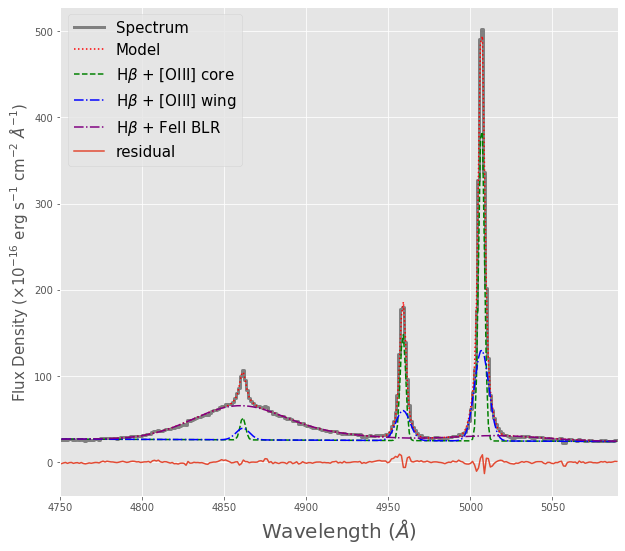

In [42]:
z = {"HE0412-0803":0.038160}

objs = z.keys()

broad2= {'HE0412-0803':False}
#'HE0021-1810':False,
p_init= {'HE0412-0803':[25.99180256003626, 377.9031193250989, 11462.654025373835, 77.58928413208905, 13.453612486745723, 105.6762550383936, 11464.515613291425, 260.88617467212305, 39.13610324144671, 6.147385080032044, 11324.476857821213, 1802.6434849928783, 0.0, 0.0, 11448.0, 1000.0, -7.92244618857034, 65.95450582026812]}
#'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   